In [172]:
# load the data
import numpy as np
from sklearn.cluster import KMeans, MeanShift
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [173]:
data = np.load('/Users/dhruvkumar/Desktop/clusters.npy')
print (len(data),data.dtype.names)

1107 ('MEM_MATCH_ID', 'Z', 'RA', 'DEC')


In [174]:
# tangent plane to the sky
ra0, dec0 = data['RA'].mean(), data['DEC'].mean()
X = np.dstack(((ra0-data['RA'])*np.cos(data['DEC']*np.pi/180), data['DEC']-dec0))[0]

Text(0, 0.5, '$\\Delta$Dec [deg]')

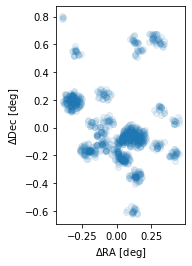

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(X[:,0], X[:,1], alpha=0.1)
ax.set_xlabel('$\Delta$RA [deg]')
ax.set_ylabel('$\Delta$Dec [deg]')

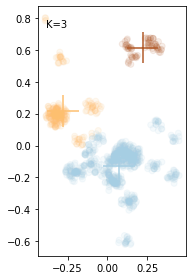

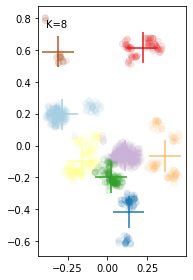

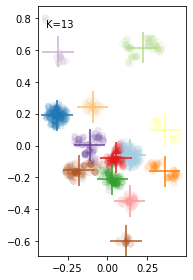

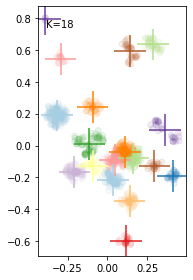

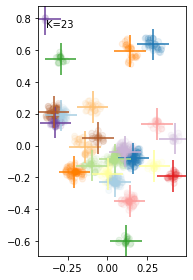

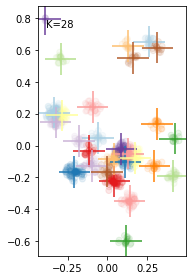

In [176]:
for K in range(3,30,5):
    clf = KMeans(n_clusters=K)
    labels = clf.fit_predict(X)
    centers = clf.cluster_centers_
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X[:,0], X[:,1], c=labels, alpha=0.1, cmap='Paired')
    ax.scatter(centers[:,0], centers[:,1], c=np.arange(1,K+1), s=1000, marker='+', cmap='Paired')
    ax.text(0.05, 0.95, 'K=%d' % K, va='top', transform=ax.transAxes)
    fig.tight_layout()

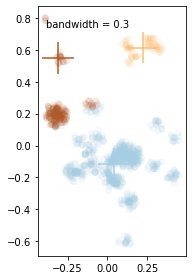

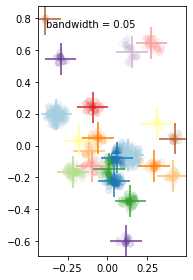

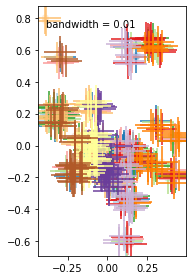

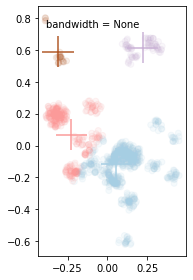

In [177]:
for b in [0.3, 0.05, 0.01, None]:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(X)
    centers = ms.cluster_centers_
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X[:,0], X[:,1], c=labels, alpha=0.1, cmap='Paired')
    ax.scatter(centers[:,0], centers[:,1], c=np.arange(1,len(centers)+1), s=1000, marker='+', cmap='Paired')
    ax.text(0.05, 0.95, 'bandwidth = %r' % b, transform=ax.transAxes, va='top')
    fig.tight_layout()

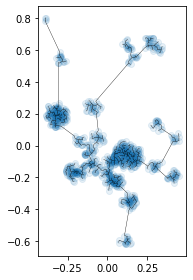

In [178]:
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph

G = kneighbors_graph(X, n_neighbors=100, mode='distance')
T = minimum_spanning_tree(G).toarray()
one,two = np.where(T>0)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(X[:,0], X[:,1], alpha=0.1)
plt.quiver(X[one,0], X[one,1], X[two,0]-X[one,0], X[two,1]-X[one,1], angles='xy', scale_units='xy', scale=1, headwidth=0, headaxislength=0, headlength=0, minlength=0)
fig.tight_layout()

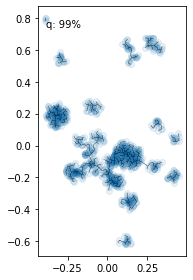

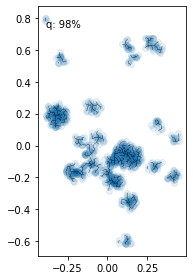

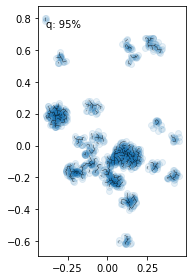

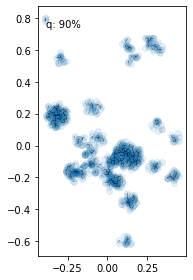

In [179]:
# remove the 90 .. 99 percentile longest edges
perc = [90,95,98,99]
cuts = np.percentile(T[T>0],perc)
for i in range(len(perc))[::-1]:
    one,two = np.where((T>0) & (T<cuts[i]))
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X[:,0], X[:,1], alpha=0.1)
    plt.quiver(X[one,0], X[one,1], X[two,0]-X[one,0], X[two,1]-X[one,1], angles='xy', scale_units='xy', scale=1, headwidth=0, headaxislength=0, headlength=0, minlength=0)
    ax.text(0.05, 0.95, 'q: %d%%' % perc[i], transform=ax.transAxes, va='top')
    fig.tight_layout()

1 0.7759986245311765 0.016332276103462034
2 0.6365039509443111 0.016010129906897392
3 0.8402518120987117 0.018160652262012834
4 0.8898567076408508 0.02484614309276356
5 0.9509299646505496 0.020212020956758538
6 0.9533076446615372 0.014768169899623115
7 1.0618135583076684 0.021998443851904668
8 1.1533904267582331 0.016160120626973785
9 1.251653548877109 0.012978347919605964
10 1.3555775553468297 0.016785396463522093
11 1.433822038682973 0.013546330602555695
12 1.5206481353120458 0.01019969273929953
13 1.6068431584694554 0.012662124142085427
14 1.6552247351983096 0.01513129399127573
15 1.704164968473328 0.021068516664027436
16 1.7511311161463277 0.014873817313175669
17 1.782722909516651 0.011548471166072998
18 1.830677824172672 0.014250345594235036
19 1.8674662304661673 0.015895495280790612
20 1.8870891708851447 0.013065395079685233
21 1.9224768293795262 0.015703932961483782
22 1.9372720752484234 0.025565328037960137
23 1.9552443244711142 0.02066193613576339
24 1.959532177897234 0.019973

<ErrorbarContainer object of 3 artists>

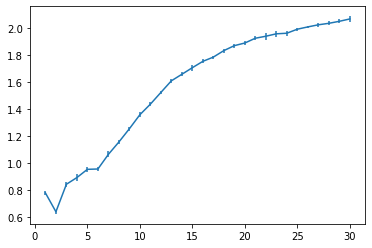

In [180]:
def getWK(X, labels, ord=None):
    clusters = np.unique(labels)
    K = clusters.size
    W = 0
    for l in clusters:
        sel = labels == l
        N = sel.sum()
        # TODO: for more general norms, the square isn't correct!
        D = np.sum([np.sum(np.linalg.norm(Xi - X[sel], ord=ord)**2) for Xi in X[sel]])
        W += D/(2*N)
    return W

def getGap(X, method, K, ref_dist, ord=None, B=10):
    N = len(X)
    log_WK = []
    log_WK_ref = []
    for b in range(B):
        cm = method(n_clusters=K)
        labels = cm.fit_predict(X)
        log_WK.append(np.log(getWK(X, labels, ord=ord)))
        ref_sample = ref_dist(N)
        cm = method(n_clusters=K)
        ref_labels = cm.fit_predict(ref_sample)
        log_WK_ref.append(np.log(getWK(ref_sample, ref_labels, ord=ord)))
    l = np.mean(log_WK_ref)
    s = np.std(log_WK_ref) * np.sqrt(1 + 1./B)
    return l - np.mean(log_WK), s

def doGapSweep(X, method, ref_dist, Kmax=10, ord=None, B=10):
    g = []
    s = []
    labels = []
    for iK in range(0,Kmax):
        K = iK+1
        g_, s_ = getGap(X, method, K, ref_dist)
        print (K, g_, s_)
        g.append(g_)
        s.append(s_)
    return range(1,Kmax+1), g, s
        
def uniform_NDbb(N, D=1, bb=None):
    sample = np.random.uniform(size=(N,D))
    if bb is not None:
        sample = bb[0] + (bb[1]-bb[0])*sample
    return sample
from functools import partial
bb = X.min(axis=0), X.max(axis=0)
N = len(X)
ref_dist = partial(uniform_NDbb, D=X.shape[1], bb=bb)
K, g, s = doGapSweep(X, KMeans, ref_dist, Kmax=30)
plt.errorbar(K,g,yerr=s)